In [2]:
import scipy.io.wavfile
from IPython.display import Audio
import soundfile as sf
from scipy import signal

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_signal(x, k_lim = 11025):
    x = x[:k_lim]
    plt.figure(figsize=[6, 4], dpi=120)
    k = np.arange(len(x))
    plt.plot(k, x, 'g')
    plt.xlabel("k")
    plt.ylabel("x[k]")
    plt.xlim([0, len(x)])
    plt.title("Signal x[k]")
    plt.grid()

def plot_periodic_signal(x, f, fs=44100):
    idx_period = (int)(fs / f)
    x = x[:idx_period]
    plt.figure(figsize=[6, 4], dpi=120)
    k = np.arange(len(x))
    plt.plot(k, x, 'g')
    plt.xlabel("k")
    plt.ylabel("x[k]")
    plt.xlim([0, len(x)])
    plt.title("Periodic Signal x[k]")
    plt.grid()

In [4]:
def zero_one_interval(x, invert=False, limits=True):
    assert((np.min(x) >= 0. and np.max(x) <= 1.) or limits == False)
    if invert:
        return 1 - 0.5*(-np.cos(x * np.pi) + 1)
    else:
        return 0.5*(-np.cos(x * np.pi) + 1)

def gen_sample(periodic_func, A=1., f=440., phase_coef=0., fs=44100, duration_ms=1000, reverse_k=False):
    assert(fs > 0 and fs <= 44100)
    assert(np.min(f) >= 0. and np.max(f) <= fs)
    assert(np.min(A) >= 0. and np.max(A) <= 1.)
    assert(np.min(phase_coef) >= 0. and phase_coef <= 1.)
    k = np.zeros((int)(fs * duration_ms / 1000))
    if not reverse_k:
        k = np.arange((int)(fs * duration_ms / 1000)) / fs
    else:
        k = np.arange((int)(fs * duration_ms / 1000), 0, -1) / fs
    func = periodic_func(k, A, f, phase_coef)
    assert(len(func) == len(k))
    assert(np.max(func) <= 1. and np.min(func) >= 0.)
    return func

# Requirement: k in [0;1] on 1sec (or fs ticks) = t in seconds
# f in Hz
# A in [0; 1]
# phase_coef in [0;1]
def sin_wave_0(k, A, f, phase_coef):
    return A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)

def sq_wave_0(k, A, f, phase_coef):
    sig = np.zeros(len(k))
    k = np.arange(len(k))
    for i in range(len(k)):
        if ((k[i] * f) % np.max(k)) > (0.5 * np.max(k)):
            sig[i] = 1.
    return sig

def sin_wave_dist_0(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    for i in range(len(wave)):
        if wave[i] > 0.95 * A:
            wave[i] = 0.95 * A
        elif wave[i] < 0.05 * A:
            wave[i] = 0.05 * A
    return wave

def sin_wave_dist2_0(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    for i in range(len(wave)):
        if wave[i] > 0.8 * A:
            wave[i] = 0.98 * wave[i]
        elif wave[i] < 0.2 * A:
            wave[i] = 1.02 * wave[i]
    return wave

def sin_wave_noise_0(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    r = np.random.normal(0, 0.01, len(k))
#     r = 0.02*np.sin(2*np.pi*k*5000)
    wave = wave + r
    for i in range(len(wave)):
        if wave[i] < 0.:
            wave[i] = 0.
        elif wave[i] > 1.:
            wave[i] = 1.
    return wave

def drum_wave_0(k, A, f, phase_coef):
    r = np.random.normal(0, 0.01, len(k))
    sig = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1) + (r * f / np.max(f))
    for i in range(len(sig)):
        if sig[i] > 1.:
            sig[i] = 1.
        elif sig[i] < 0.:
            sig[i] = 0.
    return sig

def drum_wave_noise_0(k, A, f, phase_coef):
    r = np.random.normal(0, 0.01, len(k))
    sig = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)# + (r * f / np.max(f))
    for i in range(len(sig)):
        if sig[i] > 1.:
            sig[i] = 1.
        elif sig[i] < 0.:
            sig[i] = 0.
    return sig

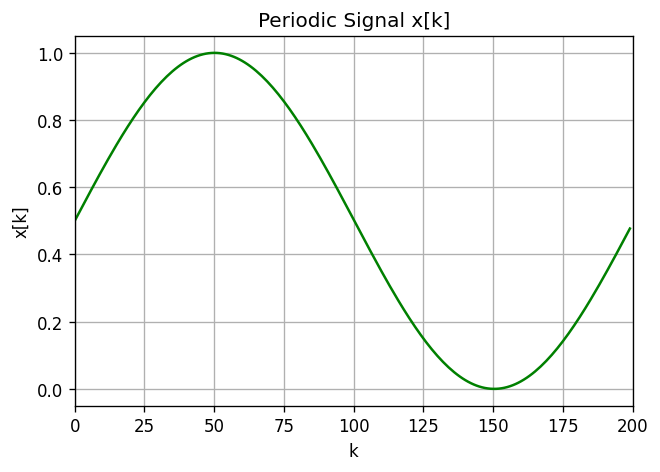

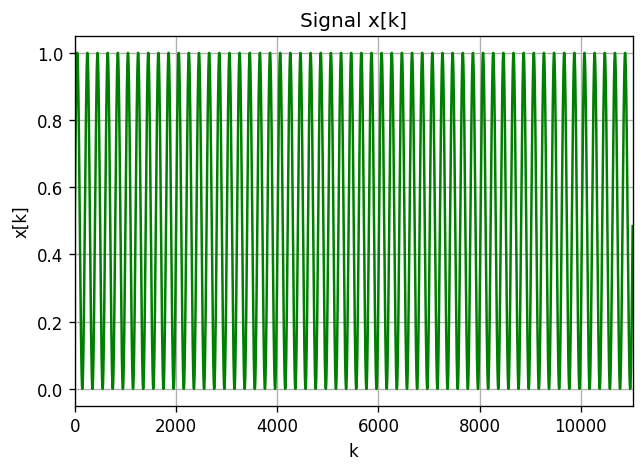

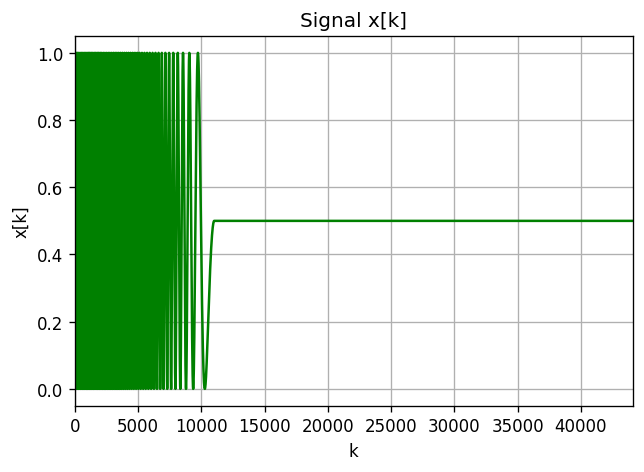

In [5]:
fs = 44100
# garmonics
f = 440 / 2
phase_coef = 0. # 0.25
A = 1

sin_wave = gen_sample(sin_wave_0, A, f, phase_coef, fs)
sin_wave2 = gen_sample(sin_wave_0, A, f * 3/2, phase_coef)
sin_wave3 = gen_sample(sin_wave_0, A, f * 5/3, phase_coef)
sq_wave = gen_sample(sq_wave_0, A, f, phase_coef)
plot_periodic_signal(sin_wave, f, fs)
plot_signal(sin_wave)

# non-garmonics
f_array = np.zeros(fs) # np.arange(fs*8, 0, -1) / (fs*8) * 440.
tmp = 440.
for i in range(fs):
    f_array[i] = tmp
    tmp = tmp - 2*440 / fs
    if tmp < 0.5*440:
        tmp = 0
#     print(f_array[i])
f_array = np.pad(f_array, (0, fs), 'constant')
drum_wave = gen_sample(drum_wave_noise_0, A, f_array, phase_coef, duration_ms=2000, reverse_k=False)
plot_signal(drum_wave, (int)(44100))

In [6]:
def gen_sample2(monotonic_func, A_min=1., A_max=1., A_T=0., f_min_hz=220., f_max_hz=440., f_T=1., phase=0., duration_ms=1000, fs_ticks=44100):
    k_max = (int)(fs * duration_ms / 1000)
    # [0;1] - t in secs
    k = np.arange(k_max) / k_max
    
    periodic_k = lambda x, f: 0.5*(np.cos(2*np.pi * x * f)+1) 
    fallen_k = lambda x: np.linspace(1, 0, k_max)
    
    

In [7]:
def gen_soundwave(sample, duration_ms, rise, decay, fs=44100, limit=1.):
    assert(rise >= 0. and rise <= 1.)
    assert(decay >= 0. and decay <= 1.)
    k_max = (int)(duration_ms / 1000. * fs)
    front = (np.arange(k_max) / (k_max * rise))**2
    back = ((k_max - np.arange(k_max)) / (k_max * decay))**2
    for i in range(k_max):
        if front[i] > 1.:
            front[i] = 1.
        if back[i] > 1.:
            back[i] = 1.
    
    sound = np.zeros(k_max)
    assert(len(front) == len(sound))
    for i in range(k_max):
        sound[i] = sample[i % ((int)(limit * len(sample)))] * front[i] * back[i]
    return sound

In [340]:
sample = (drum_wave)
sound = gen_soundwave(sample, 16000, 0.1, 0.2, fs, 1.)

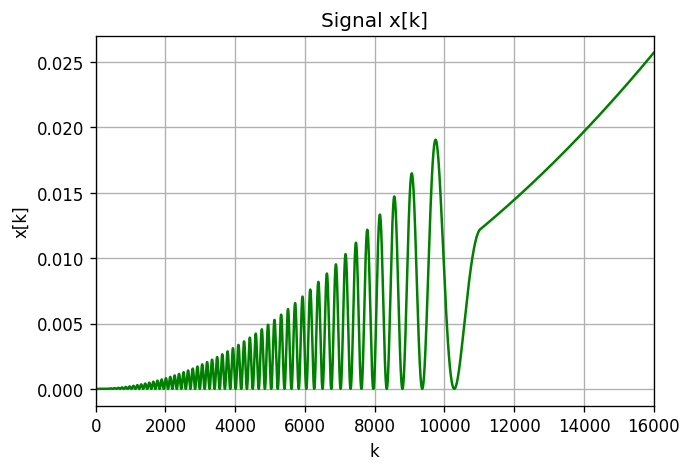

In [341]:
plot_signal(sound, k_lim=16000)

In [342]:
def filter(wave, fs = 44100, f = 4, phase_coef = 0):
    limit = len(wave)
    k = np.arange(limit) / fs
    filt = 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    return wave * filt

def filter_2(wave, fs = 44100, f = 512, f_ext = 64, phase_coef = 0.25):
    limit = len(wave)
    k = np.arange(limit) / limit
    f_range = f * 0.5 * (np.sin(2 * np.pi * k * f_ext - 2 * np.pi * phase_coef) + 1)
    filt = np.zeros(limit)
    for i in range(limit):
        filt[i] = 0.2 * (np.sin(k[i] * 2 * np.pi * f_range[i]) + 1)
    return wave * filt

def filter_3(wave, fs = 44100, f_min = 2, f_max = 20, f_ext = 2, phase_coef = 0.25):
    limit = len(wave)
    duration_freq = limit / fs
    print(duration_freq)
    k = np.arange(limit) / fs
    phase = 2 * np.pi * phase_coef
#     f_range = f * 0.5 * (np.sin(2 * np.pi * k * duration_freq * f_ext - phase) + 1)
#     f_range = np.ones(limit) * duration_freq * f_min
    f_range = (f_min * np.ones(limit) + 0.5*(f_max-f_min)*(np.sin(np.pi*k * f_ext - phase) + 1))
    f_range_plot = (f_min * np.ones(limit) + 0.5*(f_max-f_min)*(np.sin(2 * np.pi*k * f_ext - phase) + 1))
    plot_signal(f_range_plot, limit)
    filt = np.zeros(limit)
    for i in range(limit):
        filt[i] = 0.5 * (np.sin(2 * np.pi * i /fs * f_range[i]) + 1) # * duration_freq * f_ext
        filt[i] = 0.5 * (np.sin(2 * np.pi * f_range[i]) + 1) # * duration_freq * f_ext
    result = wave * filt
#     plot_signal0(result, limit)
    return result

In [371]:
file_name = 'test'
output = sf.SoundFile(f'./{file_name}.wav', 'w', samplerate=44100, channels=1)
output.write(filter_2(sound))
Audio(f'./{file_name}.wav')

In [254]:
def sin_wave_(k, A, f, phase_coef):
    return A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)

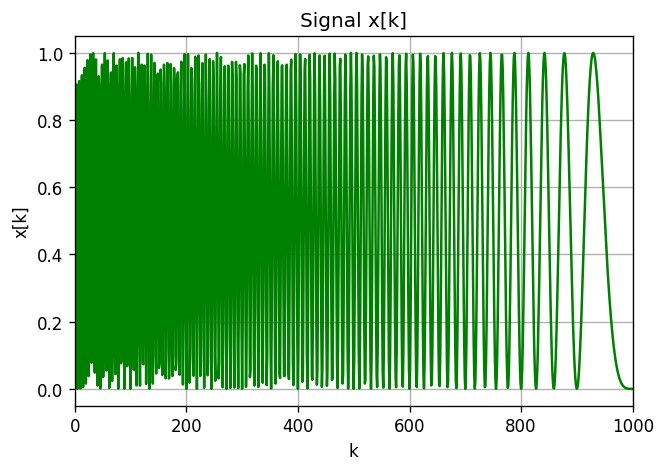

In [255]:
k = np.arange(1000, 0, -1) / 1000
f = np.arange(1000, 0, -1) / 10
A = 1
p = 0.25

plot_signal(sin_wave_(k, A, f, p), 10000)

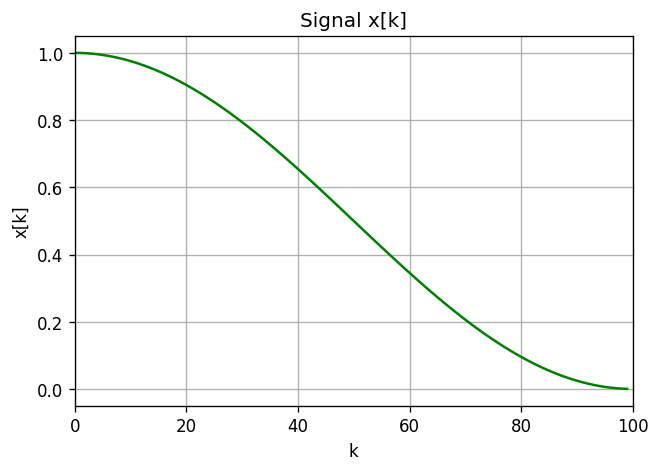

In [319]:
plot_signal(zero_one_interval(np.arange(0, 1, 0.01), invert=True))

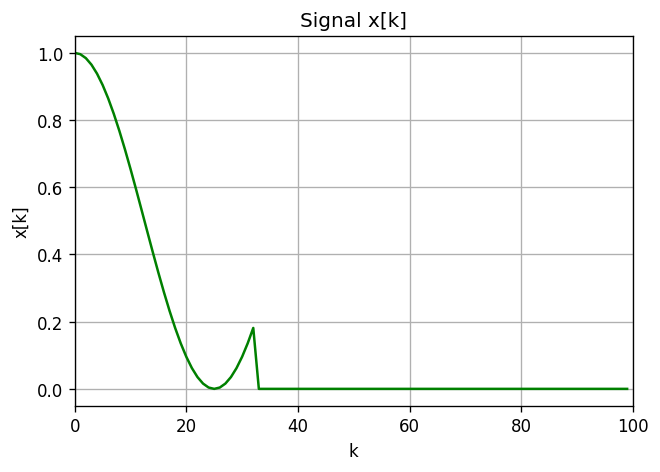

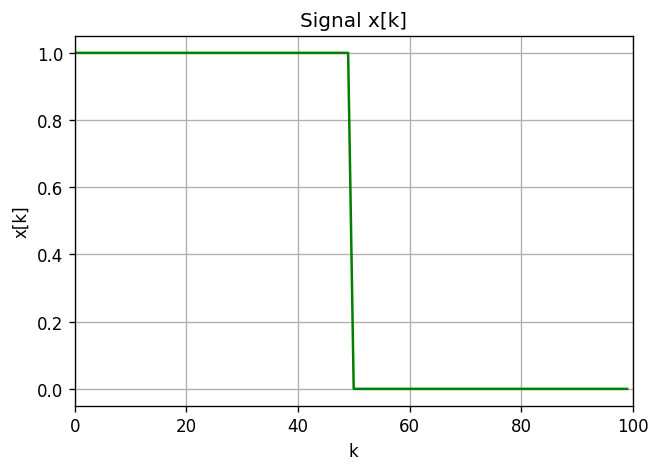

In [370]:
periodic = lambda x: 0.5*(np.cos(2 * np.pi * x*2) + 1) * np.round(np.linspace(0.75, 0, len(x)))
# periodic = lambda x: signal.square(2 * np.pi * x)
plot_signal(periodic(np.arange(0,1, 0.01)))
plot_signal(np.round(np.linspace(1, 0, len(np.arange(0,1, 0.01)))))

In [359]:
a = np.linspace(1, 0, 100)
np.round(a)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])